In [1]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# word by freq 
# wordcloud


In [2]:
import pandas as pd
import numpy as np 
import re

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
#!pip install pyLDAvis

In [4]:
df = pd.read_csv('beforecovid.csv')
df.head() #Filter by dates and then keep text?

df = df[["Date","text"]]

df["Year"] = df["Date"].str.split("-").str[2]



# drop 
# groupby year 
# LDA 
# bert 

In [5]:
df

,Date,text,Year
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19
2,15-May-17,"wainism said:\r\nOK, a bit complicated.\r\nMy ...",17
3,15-May-17,henrylbh said:\r\nGood news for you and for me...,17
4,15-May-17,wainism said:\r\nCongratulations! Sounds aweso...,17
...,...,...,...
17508,12-Oct-19,Van Holland Former Toho Mansion Holland Villag...,19
17509,13-Oct-19,Another project:\nFinal 15 units of T.O.P Read...,19
17510,13-Oct-19,Zetrio2006 said:\nAnother project:\nFinal 15 u...,19
17511,13-Oct-19,bolster said:\nWow... did you try walking to t...,19


In [6]:
df["Year"].value_counts()

19    6057
17    4785
18    4437
20    2234
Name: Year, dtype: int64

In [7]:
df_assigned = df

In [8]:
df_assigned = df_assigned.reset_index(drop=True)

# Data cleaning

In [9]:
# Remove non-English words

# remove punc 
df_assigned['clean_text']  = df_assigned['text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: x.lower())
# tokenize
df_assigned['clean_text']  = [word_tokenize(row) for row in df_assigned['clean_text']]

# remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: remove_stopwords(x))


In [10]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df_assigned['clean_text'] = df_assigned['clean_text'].apply(lambda x: lemmatization(x))


df_assigned.head()

,Date,text,Year,clean_text
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,"[mine, year, resale, bomb, shelter, aircon, le..."
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,"[kimurayuki, year, resale, bomb, shelter, airc..."
2,15-May-17,"wainism said:\r\nOK, a bit complicated.\r\nMy ...",17,"[wainism, bit, dad, house, family, reason, sis..."
3,15-May-17,henrylbh said:\r\nGood news for you and for me...,17,"[henrylbh, news, branch, office, time, removal..."
4,15-May-17,wainism said:\r\nCongratulations! Sounds aweso...,17,"[wainism, congratulation, branch, office, effe..."


In [11]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df_assigned['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '

description_str

'mine year resale bomb shelter aircon ledge noise traffic supermarket loading bay crazyclubx time rent punggol house end peace change u buy wait year move door noise door inconsiderate neighbour r pain kimurayuki year resale bomb shelter aircon ledge noise traffic supermarket loading bay year resale home traffic road traffic noise sleep aircon noise neighbour door am thing am time ppl sleep law inconsiderate neighbour wainism bit dad house family reason sister brother property house level masionette dad year loan year renovation lawrence wong ser bit flat wah thinking exercise end goal masionette name transfer buy issit loan buy masionette dad sale proceed house henrylbh news branch office time removal father ownership sis year info act act father ownership week month act jan year ira stamp duty removal name stamp duty branch manager staff stamp duty case admin fee removal name consideration sis owner congratulation branch office effect transfer ownership payment reason hardship ira br

In [12]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
# wordcloud.to_file("wordcloud_before_covid.png")



# Topic Modeling for Text


## Create Corpus 

In [13]:
data_lemmatized = df_assigned['clean_text'].tolist()
print(data_lemmatized[:10])

[['mine', 'year', 'resale', 'bomb', 'shelter', 'aircon', 'ledge', 'noise', 'traffic', 'supermarket', 'loading', 'bay', 'crazyclubx', 'time', 'rent', 'punggol', 'house', 'end', 'peace', 'change', 'u', 'buy', 'wait', 'year', 'move', 'door', 'noise', 'door', 'inconsiderate', 'neighbour', 'r', 'pain'], ['kimurayuki', 'year', 'resale', 'bomb', 'shelter', 'aircon', 'ledge', 'noise', 'traffic', 'supermarket', 'loading', 'bay', 'year', 'resale', 'home', 'traffic', 'road', 'traffic', 'noise', 'sleep', 'aircon', 'noise', 'neighbour', 'door', 'am', 'thing', 'am', 'time', 'ppl', 'sleep', 'law', 'inconsiderate', 'neighbour'], ['wainism', 'bit', 'dad', 'house', 'family', 'reason', 'sister', 'brother', 'property', 'house', 'level', 'masionette', 'dad', 'year', 'loan', 'year', 'renovation', 'lawrence', 'wong', 'ser', 'bit', 'flat', 'wah', 'thinking', 'exercise', 'end', 'goal', 'masionette', 'name', 'transfer', 'buy', 'issit', 'loan', 'buy', 'masionette', 'dad', 'sale', 'proceed', 'house'], ['henrylbh'

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [15]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'aircon'), (1, 'bay'), (2, 'bomb'), (3, 'buy'), (4, 'change'), (5, 'crazyclubx'), (6, 'door'), (7, 'end'), (8, 'house'), (9, 'inconsiderate'), (10, 'ledge'), (11, 'loading'), (12, 'mine'), (13, 'move'), (14, 'neighbour'), (15, 'noise'), (16, 'pain'), (17, 'peace'), (18, 'punggol'), (19, 'r'), (20, 'rent'), (21, 'resale'), (22, 'shelter'), (23, 'supermarket'), (24, 'time'), (25, 'traffic'), (26, 'u'), (27, 'wait'), (28, 'year'), (29, 'am'), (30, 'home'), (31, 'kimurayuki'), (32, 'law'), (33, 'ppl'), (34, 'road'), (35, 'sleep'), (36, 'thing'), (37, 'bit'), (38, 'brother'), (39, 'dad'), (40, 'exercise'), (41, 'family'), (42, 'flat'), (43, 'goal'), (44, 'issit'), (45, 'lawrence'), (46, 'level'), (47, 'loan'), (48, 'masionette'), (49, 'name')]

Total Vocabulary Size: 9949


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [16]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [17]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.5238496576109568
Perplexity Score:  -7.039608272985153

topic number:  3
Coherence Score:  0.5449857957406504
Perplexity Score:  -7.0003208760210445

topic number:  4
Coherence Score:  0.5277820340686321
Perplexity Score:  -6.981168723200641

topic number:  5
Coherence Score:  0.589187487736203
Perplexity Score:  -6.964438561186899

topic number:  6
Coherence Score:  0.564162700767625
Perplexity Score:  -7.014555394282295

topic number:  7
Coherence Score:  0.5647203322626344
Perplexity Score:  -6.994494975994398

topic number:  8
Coherence Score:  0.5745451730918347
Perplexity Score:  -7.027265119032217

topic number:  9
Coherence Score:  0.5501453399453852
Perplexity Score:  -7.075626810294687

topic number:  10
Coherence Score:  0.5655567738967405
Perplexity Score:  -7.179170534593579

topic number:  11
Coherence Score:  0.520536052582051
Perplexity Score:  -7.374368181361363

topic number:  12
Coherence Score:  0.5111613719437055
Perplexity Scor

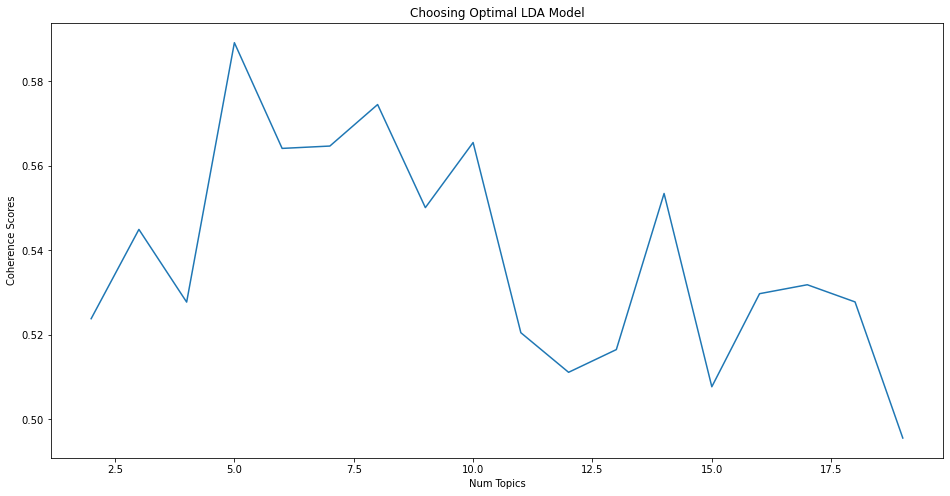

In [18]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [31]:
ntopics_des_name = 10

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [32]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.078*"property" + 0.077*"market" + 0.062*"price" + 0.029*"year" + '
  '0.020*"time" + 0.019*"developer" + 0.019*"people" + 0.017*"www" + '
  '0.015*"singapore" + 0.014*"land"'),
 (1,
  '0.043*"mrt" + 0.040*"bto" + 0.024*"punggol" + 0.023*"area" + 0.021*"block" '
  '+ 0.018*"year" + 0.016*"school" + 0.014*"line" + 0.013*"plot" + '
  '0.012*"station"'),
 (2,
  '0.108*"u" + 0.031*"school" + 0.026*"time" + 0.021*"kid" + 0.019*"timer" + '
  '0.016*"people" + 0.014*"parent" + 0.013*"place" + 0.010*"family" + '
  '0.010*"liao"'),
 (3,
  '0.043*"unit" + 0.041*"price" + 0.035*"project" + 0.028*"psf" + '
  '0.025*"condo" + 0.025*"launch" + 0.018*"development" + 0.017*"developer" + '
  '0.015*"bedder" + 0.013*"residence"'),
 (4,
  '0.021*"ris" + 0.019*"pasir" + 0.018*"water" + 0.015*"reno" + 0.015*"wall" + '
  '0.011*"problem" + 0.011*"work" + 0.011*"thing" + 0.011*"day" + '
  '0.011*"time"'),
 (5,
  '0.049*"year" + 0.028*"loan" + 0.025*"resale" + 0.022*"hdb" + 0.018*"rate" + '
  '0.017*

In [33]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [34]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df_assigned)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [35]:
df_assigned['Topic'] = topic_num

In [36]:
df_assigned

,Date,text,Year,clean_text,Topic
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,"[mine, year, resale, bomb, shelter, aircon, le...","[8, 3, 2, 9, 5, 4, 1]"
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,"[kimurayuki, year, resale, bomb, shelter, airc...","[9, 3, 4, 8, 5, 2]"
2,15-May-17,"wainism said:\r\nOK, a bit complicated.\r\nMy ...",17,"[wainism, bit, dad, house, family, reason, sis...","[5, 0, 2, 4, 6]"
3,15-May-17,henrylbh said:\r\nGood news for you and for me...,17,"[henrylbh, news, branch, office, time, removal...","[5, 4, 2, 0]"
4,15-May-17,wainism said:\r\nCongratulations! Sounds aweso...,17,"[wainism, congratulation, branch, office, effe...","[5, 2, 4, 6]"
...,...,...,...,...,...
17508,12-Oct-19,Van Holland Former Toho Mansion Holland Villag...,19,"[van, holland, toho, mansion, holland, village...","[1, 6, 9, 3, 7, 4, 8]"
17509,13-Oct-19,Another project:\nFinal 15 units of T.O.P Read...,19,"[project, unit, boutique, project, holland, di...","[1, 6, 3, 9, 8, 0]"
17510,13-Oct-19,Zetrio2006 said:\nAnother project:\nFinal 15 u...,19,"[project, unit, boutique, project, holland, di...","[1, 6, 3, 9, 8, 0]"
17511,13-Oct-19,bolster said:\nWow... did you try walking to t...,19,"[bolster, holland, mrt]","[7, 6, 1, 5, 3, 0, 2, 4, 8, 9]"


In [37]:
des_name_final = df_assigned[['Date', 'text', 'clean_text', 'Topic']]
des_name_final.head()

,Date,text,clean_text,Topic
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...","[mine, year, resale, bomb, shelter, aircon, le...","[8, 3, 2, 9, 5, 4, 1]"
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,"[kimurayuki, year, resale, bomb, shelter, airc...","[9, 3, 4, 8, 5, 2]"
2,15-May-17,"wainism said:\r\nOK, a bit complicated.\r\nMy ...","[wainism, bit, dad, house, family, reason, sis...","[5, 0, 2, 4, 6]"
3,15-May-17,henrylbh said:\r\nGood news for you and for me...,"[henrylbh, news, branch, office, time, removal...","[5, 4, 2, 0]"
4,15-May-17,wainism said:\r\nCongratulations! Sounds aweso...,"[wainism, congratulation, branch, office, effe...","[5, 2, 4, 6]"


In [38]:
des_name_final.to_csv('description_name_features_final_all_noun.csv', index=False) 

### Model Evaluation

In [39]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.198803924422906
Coherence Score:  0.5461923261803017


## Visualisation

In [40]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.072741  0.215804       1        1  14.412790
5     -0.169940  0.046480       2        1  13.703595
6     -0.139865  0.023811       3        1  13.198630
7      0.254048  0.110278       4        1  12.017681
0     -0.224187  0.133932       5        1   9.929956
1      0.259152  0.090086       6        1   9.652624
9      0.092110 -0.050595       7        1   9.042101
2     -0.031319 -0.155281       8        1   6.766792
8      0.082228 -0.114831       9        1   6.381540
4     -0.049487 -0.299684      10        1   4.894291, topic_info=         Term         Freq        Total Category  logprob  loglift
350       mrt  8358.000000  8358.000000  Default  30.0000  30.0000
26          u  5274.000000  5274.000000  Default  29.0000  29.0000
283      room  3229.000000  3229.000000  Default  28.0000  28.0000
51   property  4689.000000  4689.000000  Default  27.0000  27.0000
400    market  6814.000000  6814.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
212       job   175.238335   563.786122  Topic10  -4.9408   1.8486
24       time   258.420663  5184.570443  Topic10  -4.5523   0.0182
161   service   155.792825   516.330570  Topic10  -5.0584   1.8189
121      part   162.597148   706.829165  Topic10  -5.0156   1.5476
206      cost   164.020395   786.931834  Topic10  -5.0069   1.4489

[607 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2456      3  0.992963      10k
580       5  0.979967  1200psf
884       1  0.989884  1500psf
1900      4  0.993206    15min
1971      2  0.995706     200k
...     ...       ...      ...
28        7  0.005090     year
28        8  0.011029     year
28        9  0.014988     year
28       10  0.003252     year
1400      4  0.997058   yishun

[1036 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 7, 8, 1, 2, 10, 3, 9, 5])

## Word Count of Topic Keywords

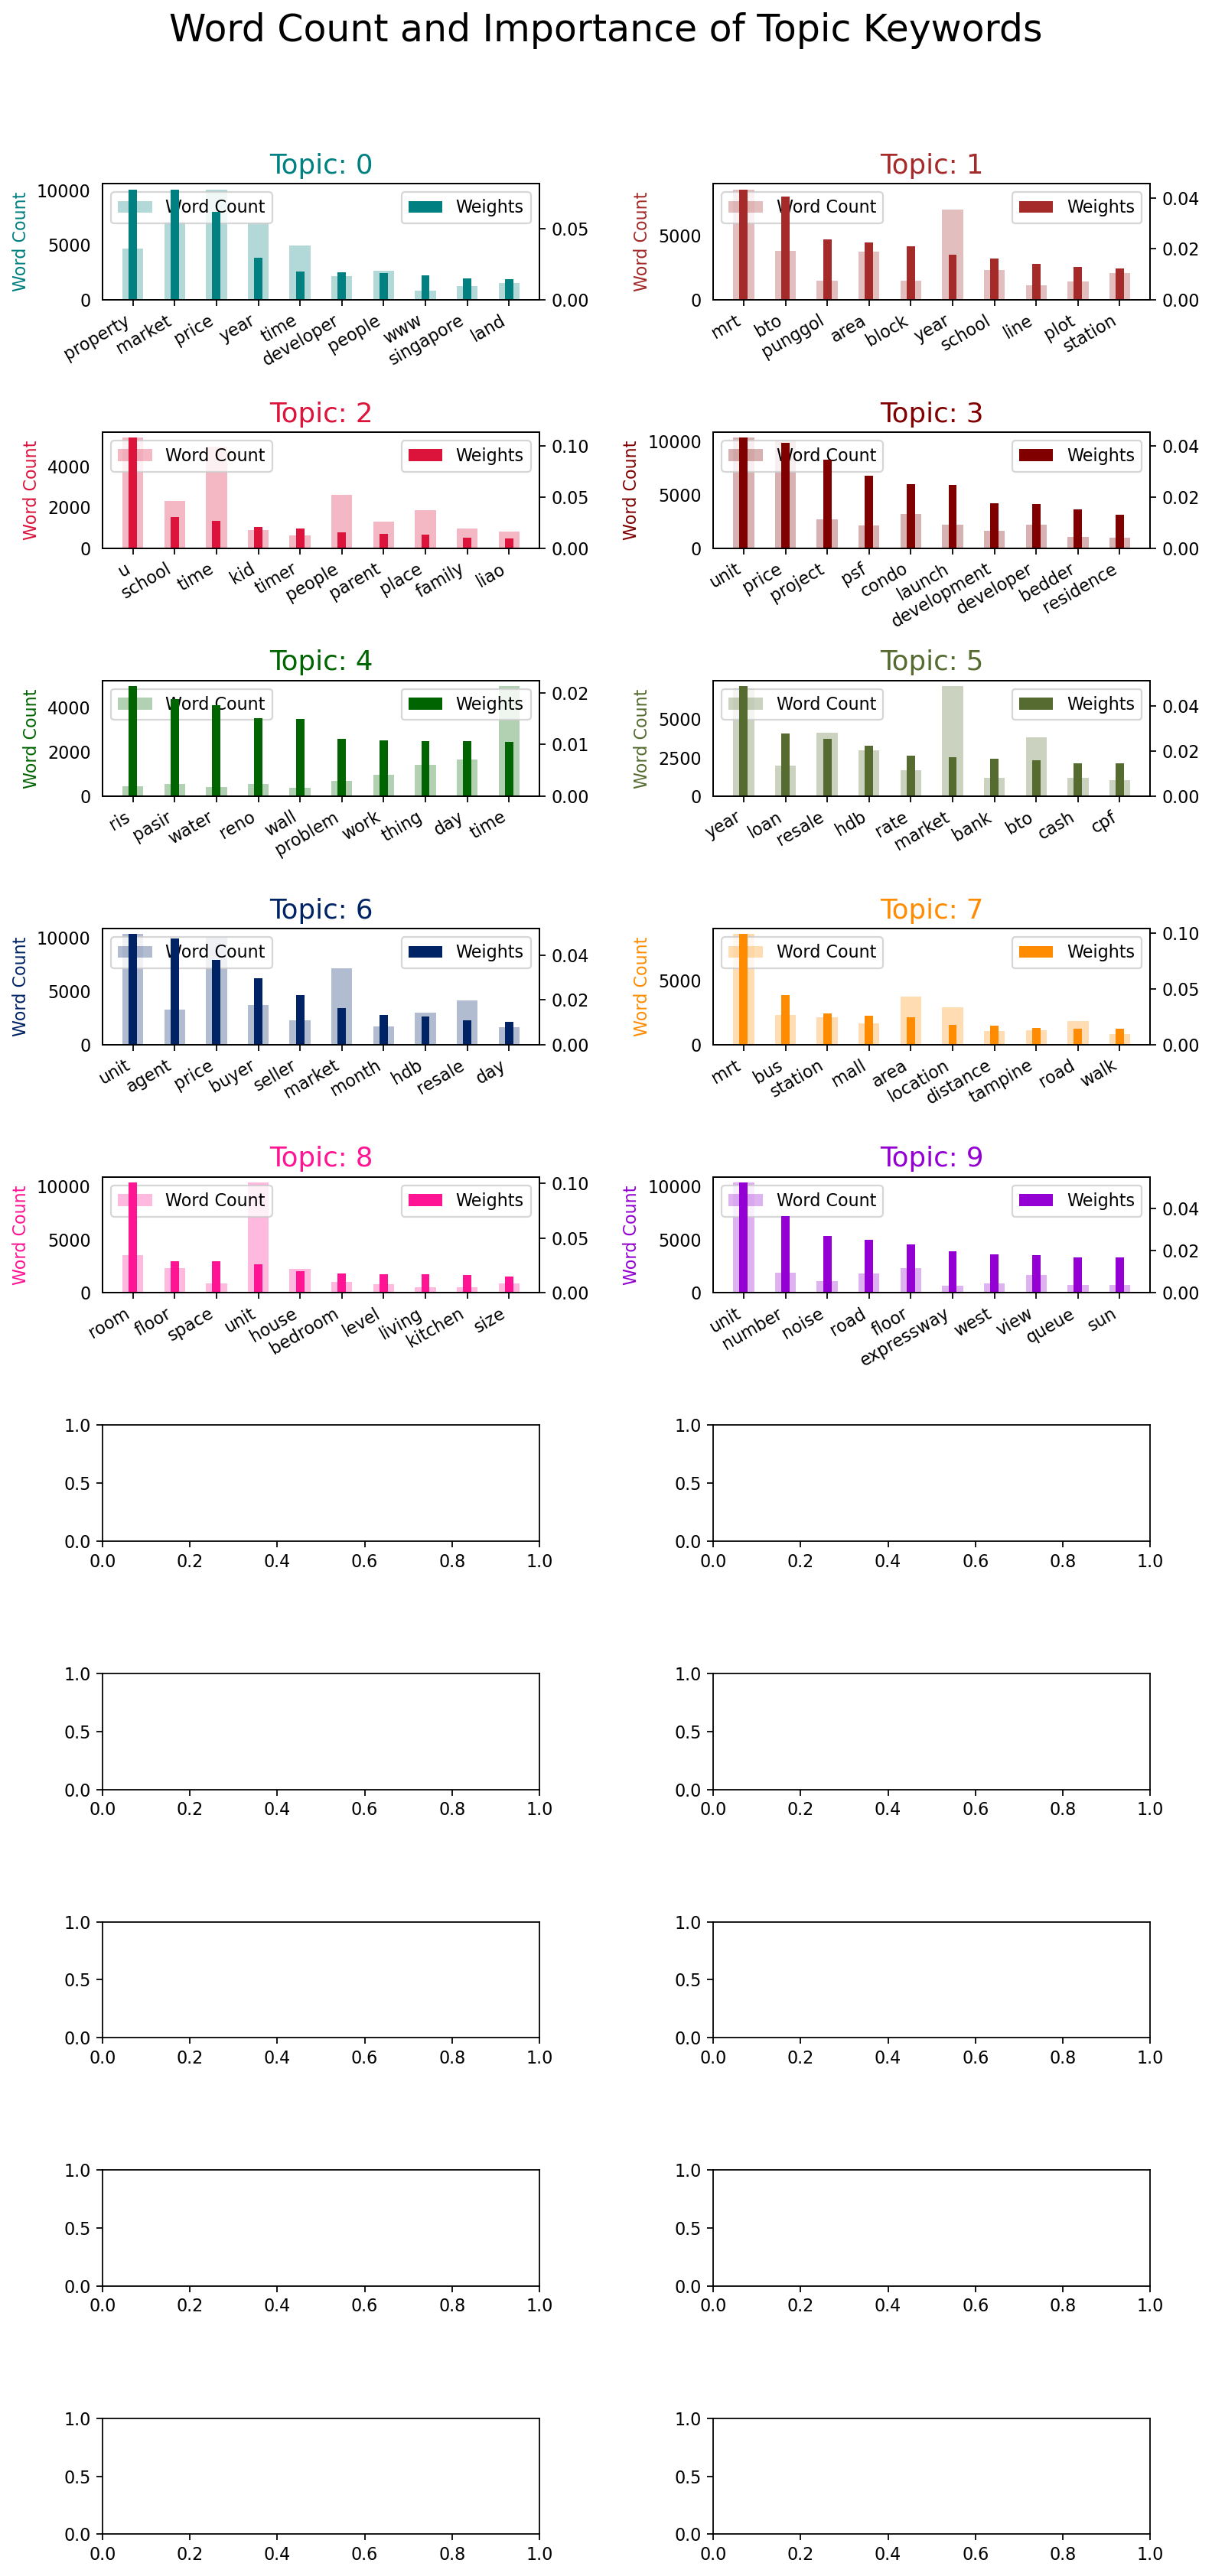

In [42]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(10, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()